<a href="https://colab.research.google.com/github/Lasitha-Jayawardana/IDS/blob/main/K_Mean_NSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import math
from sklearn.cluster import KMeans
# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
from sklearn.model_selection import GridSearchCV, cross_val_score,train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix,f1_score

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Raw Data into Python

In [2]:
# Loading the data
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IDS Project/NSL_Train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IDS Project/NSL_Test.csv')

# print the shape
print(train_data.shape)
print(test_data.shape)

train_data.drop(['id'], axis = 'columns' , inplace = True)
test_data.drop(['id'], axis = 'columns' , inplace = True)
#runs the first 5 rows
#train_data.head()

(125973, 43)
(22544, 43)


# Data Preprocessing ¶

In [8]:
#train_data.info()

In [3]:
#convert object data to categorical
train_data[['protocol_type', 'service', 'flag','class']]= train_data[['protocol_type', 'service', 'flag','class']].apply(lambda x: x.astype('category'))
test_data[['protocol_type', 'service', 'flag','class']]= test_data[['protocol_type', 'service', 'flag','class']].apply(lambda x: x.astype('category'))

#train_data.info()
def checknull():
  # Checking for null values
  print(train_data.isnull().sum())
  print(test_data.isnull().sum())

In [10]:

# select categorical column and count unique values 
def showCatColumnDetails():
  
  for column in train_data.select_dtypes('category'):
    unique_vals = np.unique(train_data[column])
    nr_values = len(unique_vals)
    print('{} :{}'.format(column, nr_values))
  print(".....................protocol_type.........................\n")
  print(train_data['protocol_type'].describe())
  print("\n\n.....................service.........................\n")
  print(train_data['service'].describe())
  print("\n\n......................flag........................\n")
  print(train_data['flag'].describe())

In [11]:
#train_data.columns

In [12]:
# Looping through all the features by our y variable - see if there is relationship
def showCatGraph():

  features = ['protocol_type', 'service', 'flag', 'class']
  for f in features:
      plt.figure(figsize=(12,4)) # this creates a figure 8 inch wide, 4 inch high

      sns.countplot(x = f, data = train_data, palette = 'Set3',order = train_data[f].value_counts().iloc[:20].index)
      plt.xticks(rotation=45)
      plt.show()
    

In [4]:
train_data['class'] = train_data['class'].map( {'normal':0, 'anomaly':1} )
test_data['class'] = test_data['class'].map( {'normal':0, 'anomaly':1} )

In [14]:
# Class count
count_class_0, count_class_1 = train_data['class'].value_counts()

# Divide by class
df_class_0 = train_data[train_data['class'] == 0]
df_class_1 = train_data[train_data['class'] == 1]
    
df_class_0_under = df_class_0.sample(count_class_1)
train_data = pd.concat([df_class_0_under, df_class_1], axis=0)

In [15]:
train_data.reset_index(drop=True,inplace=True)


In [6]:
train_data.groupby('class')['class'].count()

class
1    58630
0    67343
Name: class, dtype: int64

In [11]:
#train_data['service']

In [12]:
def addOtherLabel():
  otherlabel = 'Other_service'
  others1 = train_data['service'].value_counts().index[30:]
  # apply new category label
  train_data['service'] = train_data['service'].cat.add_categories([otherlabel])
  train_data['service'] = train_data['service'].replace(others1, otherlabel)

  train_data['service'].replace({'pop_3':'Other_service','sunrpc':'Other_service',
                              'link':'Other_service','name':'Other_service','echo':'Other_service',
                              'netbios_ns':'Other_service'}, inplace = True)

  others1 = test_data['service'].value_counts().index[30:]
  # apply new category label
  test_data['service'] = test_data['service'].cat.add_categories([otherlabel])
  test_data['service'] = test_data['service'].replace(others1, otherlabel)

  test_data['service'].replace({'pop_3':'Other_service','sunrpc':'Other_service',
                              'link':'Other_service','name':'Other_service','echo':'Other_service',
                              'netbios_ns':'Other_service'}, inplace = True)


In [13]:
#addOtherLabel()

In [5]:
def removeDuplicate():
  print('Duplicates train:',train_data.duplicated().sum())
  train_data.drop_duplicates(keep='first',inplace=True)
  print(train_data.duplicated().sum())
  print('Duplicates test:',test_data.duplicated().sum())
  test_data.drop_duplicates(keep='first',inplace=True)
  print(test_data.duplicated().sum())

  train_data.reset_index(drop=True,inplace=True)
  test_data.reset_index(drop=True,inplace=True)

In [6]:
removeDuplicate()

Duplicates train: 9
0
Duplicates test: 3
0


In [7]:
limit = train_data.shape[1]-1
    
X_train = train_data.iloc[:,0:limit] # train set features
Y_train = train_data.iloc[:,limit]

X_test = test_data.iloc[:,0:limit] # test set features
Y_test = test_data.iloc[:,limit]

print('Training X   :',X_train.shape)
print('Training_Y   :',Y_train.shape)

print('Test_X       :',X_test.shape)
print('Test_Y       :',Y_test.shape)

Training X   : (125964, 41)
Training_Y   : (125964,)
Test_X       : (22541, 41)
Test_Y       : (22541,)


In [8]:
def one_hot_encode(X_train,X_test):# Making categorical variables into numeric representation by one- hot encoding
    
    categorical_cols = ['protocol_type','flag','service']

    # Training dataset one hot encoding
    ohe = OneHotEncoder(handle_unknown = 'ignore')
    ohe.fit(X_train[categorical_cols])
    array_hot_encoded1 = ohe.transform(X_train[categorical_cols]).toarray()

    data_hot_encoded1 = pd.DataFrame(array_hot_encoded1, index=X_train.index,columns=ohe.get_feature_names(categorical_cols))
    X_train = X_train.drop(columns=categorical_cols)
    X_train = pd.concat([data_hot_encoded1,X_train], axis=1)
    
    print('X_train shape :',X_train.shape)
    
    # Test dataset one hot encoding
    array_hot_encoded2 = ohe.transform(X_test[categorical_cols]).toarray()
    data_hot_encoded2 = pd.DataFrame(array_hot_encoded2, index=X_test.index,columns=ohe.get_feature_names(categorical_cols))
    X_test = X_test.drop(columns=categorical_cols)
    X_test = pd.concat([data_hot_encoded2,X_test], axis=1)
    
    print('X_test shape :',X_test.shape)
    
    return X_train, X_test



X_train, X_test = one_hot_encode(X_train,X_test)


X_train shape : (125964, 122)
X_test shape : (22541, 122)


In [18]:
#X_train

In [9]:
def featureScalling(X_train,X_test):
  scaler = StandardScaler()
  X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
  X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)
  return X_train,X_test

In [10]:
X_train,X_test = featureScalling(X_train,X_test)

In [ ]:
X_train.describe()

In [22]:
# Trying with Dimentionality reduction and then Kmeans

def showVariance(X):
  n_components = X.shape[1]

  # Running PCA with all components
  pca = PCA(n_components=n_components,random_state=456)
  X_r = pca.fit(X).transform(X)


  # Calculating the 95% Variance
  total_variance = sum(pca.explained_variance_)
  print("Total Variance in our dataset is: ", total_variance)
  var_98 = total_variance * 0.99
  print("The 98% variance we want to have is: ", var_98)
  print("")

  # Creating a df with the components and explained variance
  a = zip(range(0,n_components), pca.explained_variance_)
  a = pd.DataFrame(a, columns=["PCA Comp", "Explained Variance"])

  # Trying to hit 95%
  print("Variance explain with 30 n_compononets: ", sum(a["Explained Variance"][0:30]))
  print("Variance explain with 35 n_compononets: ", sum(a["Explained Variance"][0:35]))
  print("Variance explain with 40 n_compononets: ", sum(a["Explained Variance"][0:40]))
  print("Variance explain with 41 n_compononets: ", sum(a["Explained Variance"][0:41]))
  print("Variance explain with 50 n_compononets: ", sum(a["Explained Variance"][0:50]))
  print("Variance explain with 53 n_compononets: ", sum(a["Explained Variance"][0:53]))
  print("Variance explain with 55 n_compononets: ", sum(a["Explained Variance"][0:55]))
  print("Variance explain with 60 n_compononets: ", sum(a["Explained Variance"][0:60]))
  print("Variance explain with 65 n_compononets: ", sum(a["Explained Variance"][0:65]))
  print("Variance explain with 70 n_compononets: ", sum(a["Explained Variance"][0:70]))
  print("Variance explain with 75 n_compononets: ", sum(a["Explained Variance"][0:75]))
  print("Variance explain with 80 n_compononets: ", sum(a["Explained Variance"][0:80]))
  return pca.explained_variance_ratio_
  

In [23]:
vr = showVariance(X_train)

Total Variance in our dataset is:  4.239846183908404
The 98% variance we want to have is:  4.19744772206932

Variance explain with 30 n_compononets:  4.040085672999156
Variance explain with 35 n_compononets:  4.068236611415323
Variance explain with 40 n_compononets:  4.094027677077478
Variance explain with 41 n_compononets:  4.098895644899186
Variance explain with 50 n_compononets:  4.138733744028214
Variance explain with 53 n_compononets:  4.150632271614262
Variance explain with 55 n_compononets:  4.158222551402169
Variance explain with 60 n_compononets:  4.1762126849703645
Variance explain with 65 n_compononets:  4.1925286811815505
Variance explain with 70 n_compononets:  4.206577570035951
Variance explain with 75 n_compononets:  4.218197561367648
Variance explain with 80 n_compononets:  4.2271203280268


In [24]:
# Plotting the Data
def plotVariance(vr,k):
  plt.figure(1, figsize=(14, 8))
  plt.plot(vr, linewidth=2, c="r")
  plt.xlabel('n_components')
  plt.ylabel('explained_ratio_')

  # Plotting line with 98% e.v.
  plt.axvline(k,linestyle=':', label='n_components - 98% explained', c ="blue")
  plt.legend(prop=dict(size=12))

  # adding arrow
  plt.annotate('55 eigenvectors used to explain 98% variance', xy=(k, vr[k]), 
              xytext=(58, vr[10]),
              arrowprops=dict(facecolor='blue', shrink=0.05))

  plt.show()

In [13]:
kPCA=50
#plotVariance(vr,kPCA)

In [14]:
def runPCA(X_train,X_test):
  pca = PCA(n_components=kPCA, random_state = 453)
  X_rtrain = pca.fit(X_train).transform(X_train)
  X_rtest  = pca.transform(X_test)
  return X_rtrain,X_rtest

In [15]:
X_rtrain,X_rtest = runPCA(X_train,X_test)

# K-means Clustering

In [11]:
# Running K means with multible Ks
best_seed = None
final_centroids = None
final_cluster_assignment = None
X_value = X_train
min_inertia = []
#X_value = newdata.values
seeds = [0, 20000, 40000, 60000, 80000, 100000, 120000]
for seed in seeds:
  inertia = []
  no_of_clusters = range(2,12)
  print('\n\n seed= {} \n'.format(seed))
  for f in no_of_clusters:
      kmeans = KMeans(n_clusters=f, init='k-means++',random_state=seed)
      kmeans = kmeans.fit(X_value)
      
      u = kmeans.inertia_
      inertia.append(u)
      print("The innertia for :", f, "Clusters is:", u) 
      # if current measurement of heterogeneity is lower than previously seen,
      # update the minimum record of heterogeneity.
  if len(min_inertia) == 0 :
      min_inertia = inertia
      
  if min(inertia,default=0) < min(min_inertia,default=0):
      min_inertia = inertia
      best_seed = seed
      final_centroids = kmeans.cluster_centers_
      final_cluster_assignment = kmeans.labels_



 seed= 0 

The innertia for : 2 Clusters is: 14122824.253618982
The innertia for : 3 Clusters is: 13370685.090792077
The innertia for : 4 Clusters is: 13058427.789816279
The innertia for : 5 Clusters is: 12935306.41965943
The innertia for : 6 Clusters is: 12593007.334937662
The innertia for : 7 Clusters is: 12152430.934468025
The innertia for : 8 Clusters is: 11967585.365368247
The innertia for : 9 Clusters is: 11755126.975305123
The innertia for : 10 Clusters is: 11634102.63815199
The innertia for : 11 Clusters is: 11502244.818662662


 seed= 20000 

The innertia for : 2 Clusters is: 14496285.982379364
The innertia for : 3 Clusters is: 13810156.841469735
The innertia for : 4 Clusters is: 13058434.480705308
The innertia for : 5 Clusters is: 12931097.892541006
The innertia for : 6 Clusters is: 12588856.70906054
The innertia for : 7 Clusters is: 12148753.255536884
The innertia for : 8 Clusters is: 12113002.92669545
The innertia for : 9 Clusters is: 11873433.26021095
The innertia for : 

Text(0.5, 1.0, 'Inertia Plot per k for Best Seed 60000')

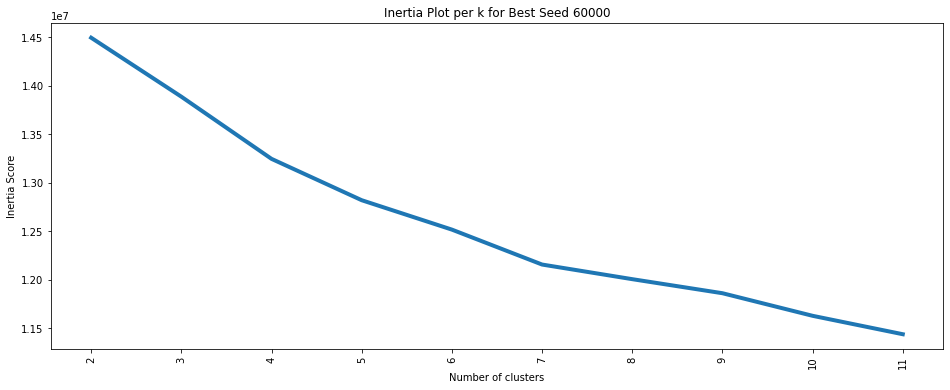

In [12]:
# Creating the scree plot for Intertia - elbow method
fig, (ax1) = plt.subplots(1, figsize=(16,6))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, min_inertia,linewidth=4)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation='vertical')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia Score')
plt.title('Inertia Plot per k for Best Seed {}'.format(best_seed))

Best K value : 5


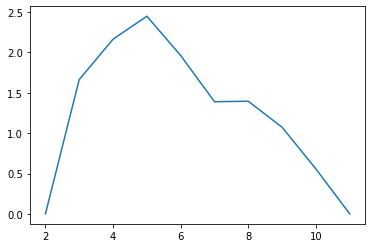

In [13]:
# between-a-point-and-a-line-in-2-d/
def calc_distance(x1, y1, a, b, c):
  d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
  return d

a = inertia[0] - inertia[-1]
b = no_of_clusters[-1] - no_of_clusters[0]
c1 = no_of_clusters[0] * inertia[-1]
c2 = no_of_clusters[-1] * inertia[0]
c = c1 - c2

r = no_of_clusters[-1]-1
r
distance_of_points_from_line = []

for k in range(int(r)):
  distance_of_points_from_line.append(
      calc_distance(no_of_clusters[k], inertia[k], a, b, c))
  
plt.plot(no_of_clusters, distance_of_points_from_line)
K =no_of_clusters[distance_of_points_from_line.index(max(distance_of_points_from_line))]
print("Best K value : {}".format(K))

In [12]:
# Running K means with multible seeds
no_of_clusters =2
def runKmeans(X_train):

  best_seed = None


  min_inertia=0.0
  
  seeds = [0,9500,10000,10500,11000,15000,18000 , 20000, 40000, 60000, 80000,90000, 120000]
  for seed in seeds:

    
    print('\n seed= {} \n'.format(seed))
        
    kmeans = KMeans(n_clusters=no_of_clusters, init='k-means++',random_state=seed)
    kmeans = kmeans.fit(X_train)
    
    inertia = kmeans.inertia_
    print("The innertia for : 2 Clusters is:", inertia) 
    # if current measurement of heterogeneity is lower than previously seen,
    # update the minimum record of heterogeneity.
    if min_inertia == 0 :
        min_inertia = inertia
        best_seed = seed
    if inertia < min_inertia:
        min_inertia = inertia
        best_seed = seed
        

  print("\nMin inertia : ", min_inertia)
  print("Best Seed : ",best_seed)
  return best_seed
 

In [13]:
best_seed = runKmeans(X_train)
#best_seed = runKmeans(X_rtrain)


 seed= 0 

The innertia for : 2 Clusters is: 336898.21025582677

 seed= 9500 

The innertia for : 2 Clusters is: 336898.2099862395

 seed= 10000 

The innertia for : 2 Clusters is: 336898.2099862395

 seed= 10500 

The innertia for : 2 Clusters is: 336898.21025582677

 seed= 11000 

The innertia for : 2 Clusters is: 336898.2099862395

 seed= 15000 

The innertia for : 2 Clusters is: 336898.2099862395

 seed= 18000 

The innertia for : 2 Clusters is: 336898.21068479883

 seed= 20000 

The innertia for : 2 Clusters is: 336898.2099862395

 seed= 40000 

The innertia for : 2 Clusters is: 336898.2099862395

 seed= 60000 

The innertia for : 2 Clusters is: 336898.2099862395

 seed= 80000 

The innertia for : 2 Clusters is: 336898.21025582677

 seed= 90000 

The innertia for : 2 Clusters is: 336898.2099862395

 seed= 120000 

The innertia for : 2 Clusters is: 336898.21025582677

Min inertia :  336898.2099862395
Best Seed :  9500


In [14]:
X_trainN = X_train
X_testN = X_test
#X_trainN = X_rtrain
#X_testN = X_rtest

In [64]:
X_trainN.shape

(125964, 5)

In [28]:
print('Training_Y 1   :',len(Y_train[Y_train==1]))

Training_Y 1   : 58621


In [15]:
# Running K means on K clusters
kmeans = KMeans(n_clusters=5,init='k-means++', random_state=best_seed)
kmeans = kmeans.fit(X_trainN)

In [16]:
print("Cluster 0")
c0 =Y_train[kmeans.labels_==0]
print("intrusion : ",len(c0[c0 == 1]))
print("normal : ",len(c0[c0 == 0]))
print("Cluster 1")
c1 =Y_train[kmeans.labels_==1]
print("intrusion : ",len(c1[c1 == 1]))
print("normal : ",len(c1[c1 == 0]))
print("Cluster 2")
c2 =Y_train[kmeans.labels_==2]
print("intrusion : ",len(c2[c2 == 1]))
print("normal : ",len(c2[c2 == 0]))
print("Cluster 3")
c3 =Y_train[kmeans.labels_==3]
print("intrusion : ",len(c3[c3 == 1]))
print("normal : ",len(c3[c3 == 0]))
print("Cluster 4")
c4 =Y_train[kmeans.labels_==4]
print("intrusion : ",len(c4[c4 == 1]))
print("normal : ",len(c4[c4 == 0]))

Cluster 0
intrusion :  5452
normal :  13422
Cluster 1
intrusion :  6180
normal :  50717
Cluster 2
intrusion :  12142
normal :  2948
Cluster 3
intrusion :  78
normal :  186
Cluster 4
intrusion :  34769
normal :  70


In [35]:
def a(num):
  if (num==3 or num == 0 or num == 1):
    return 0
  elif (num==2 or num == 4):
    return 1
  else:
    return num

r = np.array(list(map(a , kmeans.labels_)))
r

array([0, 0, 1, ..., 0, 1, 0])

In [36]:
t1= kmeans.predict(X_testN)
r_t = np.array(list(map(a , t1)))
r_t

array([1, 1, 0, ..., 0, 0, 1])

In [37]:
print("Accuracy Train: ",accuracy_score(Y_train,r)*100)
print("Accuracy test: ",accuracy_score(Y_test,r_t)*100)

Accuracy Train:  88.3077704741037
Accuracy test:  74.27354598287565


In [38]:

print("Test set precision : {:.4f}".format(precision_score(Y_test, r_t)))
print("Test set recall    : {:.4f}".format(recall_score(Y_test, r_t)))
print("Test set F1-score  : {:.4f}".format(f1_score(Y_test, r_t)))

Test set precision : 0.9879
Test set recall    : 0.5548
Test set F1-score  : 0.7106


In [89]:
print(classification_report(Y_test, r_t))

              precision    recall  f1-score   support

           0       0.62      0.99      0.76      9711
           1       0.99      0.55      0.70     12830

    accuracy                           0.74     22541
   macro avg       0.81      0.77      0.73     22541
weighted avg       0.83      0.74      0.73     22541



In [17]:
def oneVsAll(number):
  if (number ==n):
    return 0
  else:
    return 1

In [18]:
n=0
m0 = np.array(list(map(oneVsAll, kmeans.labels_)))
n=1
m1 = np.array(list(map(oneVsAll, kmeans.labels_)))
n=2
m2 = np.array(list(map(oneVsAll, kmeans.labels_)))
n=3
m3 = np.array(list(map(oneVsAll, kmeans.labels_)))
n=4
m4 = np.array(list(map(oneVsAll, kmeans.labels_)))


In [24]:
print("Accuracy Train: ",accuracy_score(Y_train,m1)*100)

Accuracy Train:  81.89482709345526


In [149]:
len(m0[m0==1]) 

34936

In [25]:
label0 = 1- kmeans.labels_
label1 = kmeans.labels_
test_label1 = kmeans.predict(X_testN)
test_label0 = 1 - test_label1


In [26]:
n=0
m0 = np.array(list(map(oneVsAll, test_label1)))
n=1
m1 = np.array(list(map(oneVsAll, test_label1)))
n=2
m2 = np.array(list(map(oneVsAll, test_label1)))
n=3
m3 = np.array(list(map(oneVsAll, test_label1)))
n=4
m4 = np.array(list(map(oneVsAll, test_label1)))

In [27]:
print("Accuracy Test: ",accuracy_score(Y_test,m1)*100)

Accuracy Test:  77.41892551350873


In [30]:
print("Test set precision : {:.4f}".format(precision_score(Y_test, m1)))
print("Test set recall    : {:.4f}".format(recall_score(Y_test, m1)))
print("Test set F1-score  : {:.4f}".format(f1_score(Y_test, m1)))

Test set precision : 0.8328
Test set recall    : 0.7548
Test set F1-score  : 0.7919


In [28]:
def accuracyScore():
  print("Accuracy Train: ",accuracy_score(Y_train,label0)*100)
  print("Accuracy Train: ",accuracy_score(Y_train,label1)*100)
  print("Accuracy Test: ",accuracy_score(Y_test,test_label0)*100)
  print("Accuracy Test: ",accuracy_score(Y_test,test_label1)*100)

In [29]:
accuracyScore()

Accuracy Train:  44.59131180337239
Accuracy Train:  15.561589025435838
Accuracy Test:  41.35575174127146
Accuracy Test:  22.15962024754891


In [19]:
print("Test set precision : {:.4f}".format(precision_score(Y_test, test_label1)))
print("Test set recall    : {:.4f}".format(recall_score(Y_test, test_label1)))
print("Test set F1-score  : {:.4f}".format(f1_score(Y_test, test_label1)))

Test set precision : 0.9978
Test set recall    : 0.1733
Test set F1-score  : 0.2954


## Temp


In [ ]:
'''# Running K means with multible Ks
best_seed = None
final_centroids = None
final_cluster_assignment = None

min_inertia = []
X_value = X_train
seeds = [0, 20000, 40000, 60000, 80000, 100000, 120000]
for seed in seeds:
  inertia = []
  no_of_clusters = range(2,15)
  print('\n\n seed= {} \n'.format(seed))
  for f in no_of_clusters:
      kmeans = KMeans(n_clusters=f, init='k-means++',random_state=seed)
      kmeans = kmeans.fit(X_value)
      
      u = kmeans.inertia_
      inertia.append(u)
      print("The innertia for :", f, "Clusters is:", u) 
      # if current measurement of heterogeneity is lower than previously seen,
      # update the minimum record of heterogeneity.
  if len(min_inertia) == 0 :
      min_inertia = inertia
      
  if min(inertia,default=0) < min(min_inertia,default=0):
      min_inertia = inertia
      best_seed = seed
      final_centroids = kmeans.cluster_centers_
      final_cluster_assignment = kmeans.labels_

      '''

In [ ]:
# Creating the screen plot for Intertia - elbow method
fig, (ax1) = plt.subplots(1, figsize=(16,6))
xx = np.arange(len(seeds))
ax1.plot(xx, min_inertia,linewidth=4)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation='vertical')
plt.xlabel('Seed value')
plt.ylabel('Inertia Score')
plt.title('Inertia Plot per 2 cluster for Seed ')

In [ ]:
fig, (ax1) = plt.subplots(1, figsize=(16,6))
plt.plot(no_of_clusters, min_inertia,linewidth=4)
plt.plot([no_of_clusters[0], no_of_clusters[-1]], [min_inertia[0], 
                        min_inertia[-1]], 'ro-',linewidth=4)
plt.show()



In [ ]:
# between-a-point-and-a-line-in-2-d/
def calc_distance(x1, y1, a, b, c):
  d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
  return d

In [ ]:
a = inertia[0] - inertia[-1]
b = no_of_clusters[-1] - no_of_clusters[0]
c1 = no_of_clusters[0] * inertia[-1]
c2 = no_of_clusters[-1] * inertia[0]
c = c1 - c2

In [ ]:
r = no_of_clusters[-1]-1
r

In [ ]:
distance_of_points_from_line = []

for k in range(int(r)):
  distance_of_points_from_line.append(
      calc_distance(no_of_clusters[k], inertia[k], a, b, c))
  
plt.plot(no_of_clusters, distance_of_points_from_line)

In [ ]:
K =no_of_clusters[distance_of_points_from_line.index(max(distance_of_points_from_line))]
print("Best K value : {}".format(K))

In [ ]:
# Running K means on K clusters

kmeans = KMeans(n_clusters=K,init='k-means++', random_state=best_seed)
kmeans = kmeans.fit(X_value)
kmeans.inertia_

predictions = kmeans.predict(X_value)




In [ ]:
# calculating the Counts of the cluster
#unique, counts = np.unique(kmeans.labels_, return_counts=True)

print(np.bincount(kmeans.labels_))


In [ ]:
# Running PCA to Visualize the data

X = X_value

y_num = predictions

pca = PCA(n_components=2, random_state = 453)
X_r = pca.fit(X).transform(X)

target_names = ["Cluster 0","Cluster 1","Cluster 2", "Cluster 3","Cluster 4","Cluster 5","Cluster 6","Cluster 7"]

# Percentage of variance explained for each components
print('Explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))

# Plotting the data
plt.figure()
plt.figure(figsize=(12,8))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'black','blue','green','yellow']
lw = 2


for color, i, target_name in zip(colors, [0, 1, 2, 3, 4,5,6,7], target_names):
    plt.scatter(X_r[y_num == i, 0], X_r[y_num == i, 1], color=color, alpha=.8, lw=lw,label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title('PCA of 2 Items')
plt.show()

In [ ]:
# Running PCA again

pca = PCA(n_components=40, random_state = 453)
X_r = pca.fit(X).transform(X)

inertia = []

#running Kmeans

for f in no_of_clusters:
    kmeans = KMeans(n_clusters=f, random_state=best_seed)
    kmeans = kmeans.fit(X_r)
    u = kmeans.inertia_
    inertia.append(u)
    print("The innertia for :", f, "Clusters is:", u)

# Creating the scree plot for Intertia - elbow method
fig, (ax1) = plt.subplots(1, figsize=(16,6))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation='vertical')
plt.xlabel('n_components Value')
plt.ylabel('Inertia Score')
plt.title("Inertia Plot per k")

In [ ]:
fig, (ax1) = plt.subplots(1, figsize=(16,6))
plt.plot(no_of_clusters, inertia,linewidth=4)
plt.plot([no_of_clusters[0], no_of_clusters[-1]], [inertia[0], 
                        inertia[-1]], 'ro-',linewidth=4)
plt.show()


In [ ]:
# between-a-point-and-a-line-in-2-d/
def calc_distance(x1, y1, a, b, c):
  d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
  return d

In [ ]:
a = inertia[0] - inertia[-1]
b = no_of_clusters[-1] - no_of_clusters[0]
c1 = no_of_clusters[0] * inertia[-1]
c2 = no_of_clusters[-1] * inertia[0]
c = c1 - c2

In [ ]:
r = no_of_clusters[-1]-1
r

In [ ]:
distance_of_points_from_line = []

for k in range(int(r)):
  distance_of_points_from_line.append(
      calc_distance(no_of_clusters[k], inertia[k], a, b, c))
  
plt.plot(no_of_clusters, distance_of_points_from_line)

In [ ]:
K =no_of_clusters[distance_of_points_from_line.index(max(distance_of_points_from_line))]
print("Best K value : {}".format(K))

In [ ]:
# Running PCA with 36 PC

# Running Kmeans with 5 Ks
kmeans = KMeans(n_clusters=5, random_state=best_seed)
kmeans = kmeans.fit(X_r)

print("Optimized K-mean innertia for cluster 5 :", kmeans.inertia_)

In [ ]:
# Running PCA to Visualize the data


pca = PCA(n_components=2, random_state = 453)
X_r = pca.fit(X_r).transform(X_r)

target_names = ["Cluster 0","Cluster 1","Cluster 2", "Cluster 3","Cluster 4"]

# Percentage of variance explained for each components
print('Explained variance ratio (PCA 2 components): %s' % str(sum(pca.explained_variance_ratio_)))

# Plotting the data
plt.figure()
plt.figure(figsize=(12,8))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'black']
lw = 2


for color, i, target_name in zip(colors, [0, 1, 2, 3, 4], target_names):
    plt.scatter(X_r[y_num == i, 0], X_r[y_num == i, 1], color=color, alpha=.8, lw=lw,label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title('PCA of 2 Items')
plt.show()